>微信搜索 **[【K同学啊】](https://mp.weixin.qq.com/s/NES9RhtAhbX_jsmGua28dA)**  关注这个分享干货的博主。


>📍 本文 **GitHub** [https://github.com/kzbkzb/Python-AI](https://github.com/kzbkzb/Python-AI) 已收录

# 一、前期工作

我的环境：

- 语言环境：Python3.6.5
- 编译器：jupyter notebook
- 深度学习环境：TensorFlow2

来自专栏：[**【深度学习100例】**](https://blog.csdn.net/qq_38251616/category_11068756.html)

## 1. 设置GPU

如果使用的是CPU可以忽略这步

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    gpu0 = gpus[0]                                        #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpu0],"GPU")

## 2. 导入数据

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

## 3. 归一化

In [3]:
# 将像素的值标准化至0到1的区间内。
train_images, test_images = train_images / 255.0, test_images / 255.0

train_images.shape,test_images.shape,train_labels.shape,test_labels.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

加载数据集会返回四个 NumPy 数组：

- train_images 和 train_labels 数组是训练集，模型用于学习的数据。
- test_images 和 test_labels 数组是测试集,会被用来对模型进行测试。

图像是 28x28 的 NumPy 数组，像素值介于 0 到 255 之间。标签是整数数组，介于 0 到 9 之间。这些标签对应于图像所代表的服装类：

|标签|类|标签|类|
|:--:|:--:|:--:|:--:|
|0|T恤/上衣|5|凉鞋
|1|	裤子   |6|衬衫
|2|	套头衫 |7|运动鞋
|3|	连衣裙 |8|包
|4|	外套   |9|短靴

## 4.调整图片格式

In [4]:
#调整数据到我们需要的格式
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

train_images.shape,test_images.shape,train_labels.shape,test_labels.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000,), (10000,))

## 5. 可视化

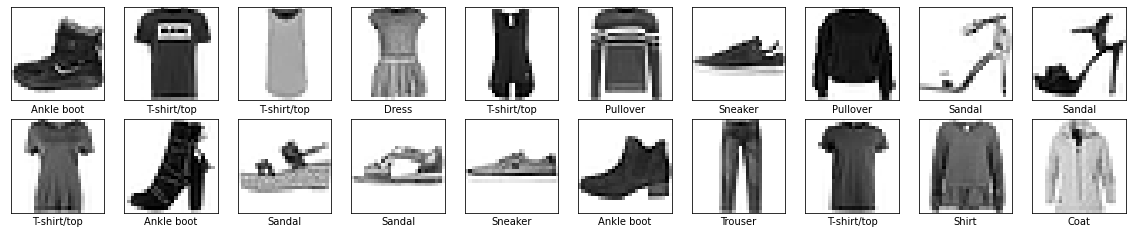

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(20,10))
for i in range(20):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

# 二、构建CNN网络

卷积神经网络（CNN）的输入是张量 (Tensor) 形式的 `(image_height, image_width, color_channels)`，包含了图像高度、宽度及颜色信息。不需要输入`batch size`。color_channels 为 (R,G,B) 分别对应 RGB 的三个颜色通道（color channel）。在此示例中，我们的 CNN 输入，fashion_mnist 数据集中的图片，形状是 `(28, 28, 1)`即灰度图像。我们需要在声明第一层时将形状赋值给参数`input_shape`。

In [6]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)), #卷积层1，卷积核3*3
    layers.MaxPooling2D((2, 2)),                   #池化层1，2*2采样
    layers.Conv2D(64, (3, 3), activation='relu'),  #卷积层2，卷积核3*3
    layers.MaxPooling2D((2, 2)),                   #池化层2，2*2采样
    layers.Conv2D(64, (3, 3), activation='relu'),  #卷积层3，卷积核3*3
    
    layers.Flatten(),                      #Flatten层，连接卷积层与全连接层
    layers.Dense(64, activation='relu'),   #全连接层，特征进一步提取
    layers.Dense(10)                       #输出层，输出预期结果
])

model.summary()  # 打印网络结构

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

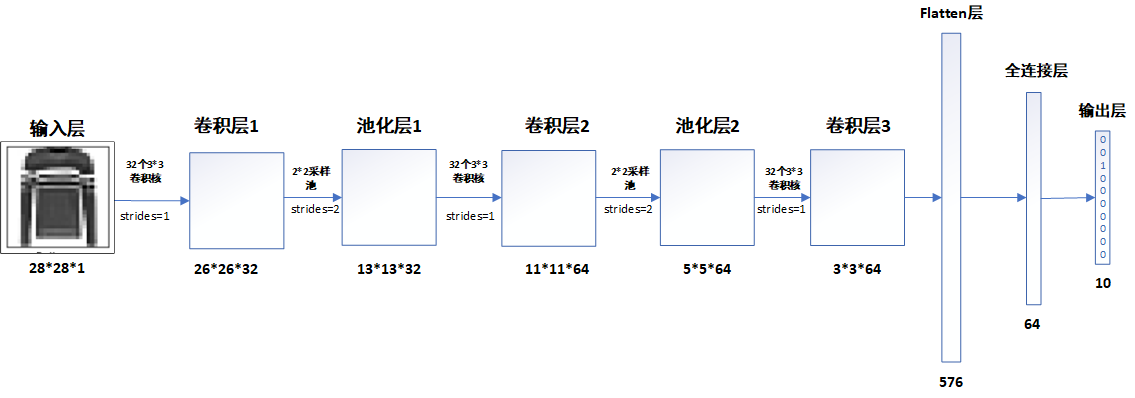

# 三、编译

在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的编译步骤中添加的：

- 损失函数（loss）：用于测量模型在训练期间的准确率。您会希望最小化此函数，以便将模型“引导”到正确的方向上。
- 优化器（optimizer）：决定模型如何根据其看到的数据和自身的损失函数进行更新。
- 指标（metrics）：用于监控训练和测试步骤。以下示例使用了准确率，即被正确分类的图像的比率。

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 四、训练模型

In [8]:
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.7005 - accuracy: 0.7426 - val_loss: 0.3692 - val_accuracy: 0.8697
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3303 - accuracy: 0.8789 - val_loss: 0.3106 - val_accuracy: 0.8855
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2770 - accuracy: 0.8988 - val_loss: 0.3004 - val_accuracy: 0.8902
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2398 - accuracy: 0.9097 - val_loss: 0.2898 - val_accuracy: 0.8968
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2191 - accuracy: 0.9195 - val_loss: 0.2657 - val_accuracy: 0.9057
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1952 - accuracy: 0.9292 - val_loss: 0.2731 - val_accuracy: 0.9036
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1791 - accuracy: 0.9322 - val_loss: 0.2747 - val_accuracy:

# 五、预测

预测结果是一个包含 10 个数字的数组。它们代表模型对 10 种不同服装中每种服装的“置信度”。我们可以看到哪个标签的置信度值最大

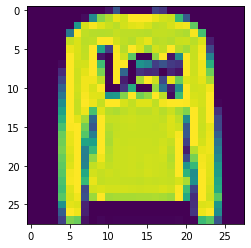

In [9]:
plt.imshow(test_images[1])

In [10]:
import numpy as np

pre = model.predict(test_images)
print(class_names[np.argmax(pre[1])])

Pullover


# 六、模型评估

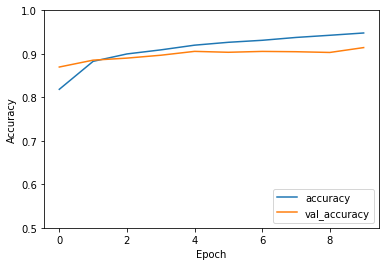

313/313 - 0s - loss: 0.2769 - accuracy: 0.9144


In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [12]:
print("测试准确率为：",test_acc)

测试准确率为： 0.9143999814987183
